In [1]:
# Moon Data Processing Notebook
### Beginning the process of processing the QAG Moon bounce data from Sep 10, 2021
#### Jon Richards - SETI Institute Quantum Astronomy Group
#### This code draws a waterfall plot from the data

In [36]:
import time

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import scipy.fftpack
from scipy.signal import argrelextrema

from datetime import datetime as dt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 4

In [37]:
# Define the path to the data file we wish to process
data_file_path = "/Volumes/QAG Disk 1/data/moon_09102021/moon_2021-09-10T22_19_57.781495_1y"
#data_file_path = "/Volumes/QAG Backup/data/moon_09102021/moon_2021-09-10T22_19_57.781495_0x"
#data_file_path = "./data/data_1x"

In [69]:
START_TIME = 1631312409.1568253092447917 #This is UTC 2021-09-10 22:20:09
SAMPLES_PER_SEC = 1920000
BYTES_PER_SAMPLE = 4
SECS_OFFSET = 3

def seek_by_time(file, datetime_str):
    """Find the offset into the file for the given datetime and seek.
    Arguments:
        file - the open file
        datetime_str - A datetime in the form 2021-09-10 22:20:09, this if UTC
    Returns:
        int - the bytes skipped in the file.
    """
    d_start = dt.strptime("2021-09-10 22:20:09", '%Y-%m-%d %H:%M:%S') 
    d = dt.strptime(datetime_str, '%Y-%m-%d %H:%M:%S') 
    diff_secs = int(dt.timestamp(d) - dt.timestamp(d_start)) + SECS_OFFSET

    bytes_to_skip = diff_secs * SAMPLES_PER_SEC * BYTES_PER_SAMPLE
    
    #print(bytes_to_skip)
    
    if file != None:
        file.seek(bytes_to_skip)
    
    return bytes_to_skip

if seek_by_time(None, "2021-09-10 22:20:10")  != 7680000:
    print("WARNING: seek_by_time() did not return the correct offset. Please check!")


In [65]:
def readBlock(file, num_samples):
    """ 
    Read the next FFT sized block of 16-bit I/Q data from an opened file.
    
    Arguments:
        file - The reference to the data file, already opened.
        num_samples - The number of 16-bit I/Q samples to read in.
            Example, If you FFT SIZE is 1024, the num_samples should
            be 1024. 2048 16-bit samples (4096 bytes total) will be 
            read and unpacked from the file.
            
        Return - A Numpy array of "num_samples" Complex64 values.
            None if the read is past the end of the file.
    
    """
    # Read the bytes from the file
    data_raw = np.fromfile(file, dtype=np.int16, count=num_samples*2)
    
    # Create a Complex64 Numpy array to hold the values
    data = np.zeros((num_samples,), dtype=np.complex64)
    
    # Reassemble the int16 aray into the Complex64 array.
    # Use a try block to catch the condition where the end of the file
    # has been passed.
    try:
        data[:] = (data_raw[0::2]) + 1j*(data_raw[1::2])
    except:
        return None
    
    return data

In [66]:
def calFreqRangeForAxis(center_hz, bw_hz):
    
    """
    For the X axis tick mark labels, calculate the frequency min/max/center
    
    Arguments:
        center_hz - The center frequency of the signal, in Hertz.
        bw_hz - The bandwidth of the signal, in Hertz.
        
    Returns - A tuple of the 
        min frequency od the signal, in MHz
        max frequency od the signal, in MHz
        center frequency od the signal, in MHz
        
    """
    min_hz = center_hz - bw_hz/2.0
    max_hz = center_hz + bw_hz/2.0
    
    return (min_hz/1000000.0, max_hz/1000000., center_hz/1000000.)

In [74]:
def create_waterfall(filename, datetime_str, num_secs, start_chan, end_chan, output_image_name=None):
    
    """Create a waterfall plot
    Arguments:
        filename - The full path filename
        datetime_str - the time offset into the file
        num_secs - number of seconds to process
        start_chan - the start frequency bin
        end_chan - the end frequency bin
        output_image_name- Optional, save an image of the plot
    """
    
    # Perform the FFT and store the result for later plotting.
    # The FFT result will be accumulated in a one dimensional Numpy array
    # of length equal to the FFT_SIZE

    # Define some constants. Here you may wish to change the FFT_SIZE
    FFT_SIZE = 1960000
    CENTER_FREQ_HZ = 1296000000
    BANDWIDTH_HZ   = 1920000
    MHZ = 1048576.0

    # Create an array to hold the data for each horizontal line of the waterfall
    bins = []

    # How many FFT_SIZE chunks to process. Ideally we would like to
    # process the entire channel, but during code development we may
    # wish to read in a smaller number. Reading in the large data files
    # takes a lot of time.
    NUM = num_secs

    # Open the file
    file = open(filename, "rb")

    seek_by_time(file, datetime_str)

    # Keep a counter of the number of FFT_SIZE length chunks we processed.
    count = 0

    # Loop through the file. 
    for i in range(NUM):

        #print(i)

        # Read the next block of data from the file
        d = readBlock(file, FFT_SIZE)

        # If None is retruned, this signifies we read to the end of the file.
        # Break out of the loop.
        if d is None:
            print("d is NONE")
            break

        yf = scipy.fftpack.fft(d, n=FFT_SIZE, axis=0)
        xx = np.abs(yf).tolist()
        yy = scipy.fft.fftshift(xx)
        bins.append(yy[start_chan:end_chan])

        # Draw a plot of the results

    #fig, ax = plt.subplots(1,1)
    fig, ax = plt.subplots(figsize=(72, 32))

    #ax.set_ylim(0, 40)

    ax.imshow(bins)

    if output_image_name != None:
        plt.savefig(output_image_name)
        
    # Show!
    plt.show()


98


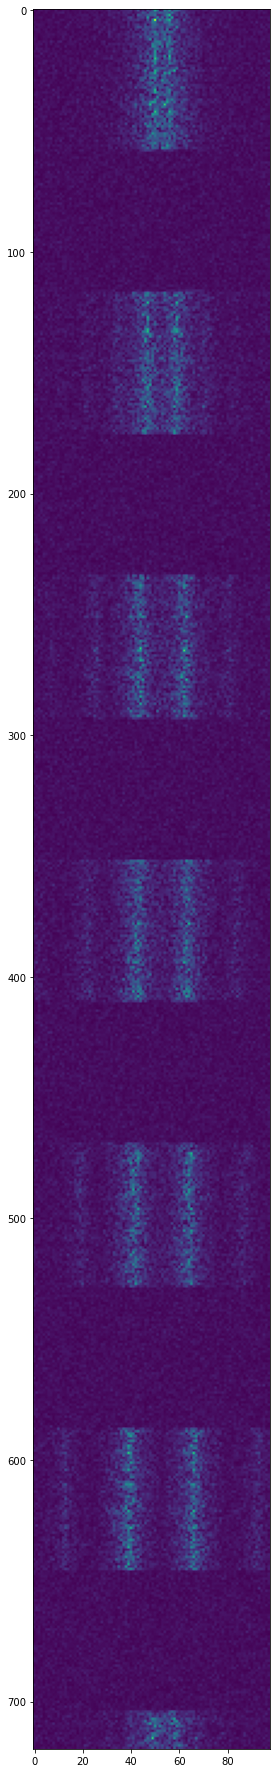

In [76]:
create_waterfall(data_file_path, "2021-09-10 23:05:00", 4*180, 1236524, 1236622, 'first_light')

In [11]:
print(len(bins[119]))

1960000
